In [1]:
# Questions
# what cards taken in Spirit Island go to the best winrate?
# Which spirit most needs the right elements? i.e. shows the greatest increased winrate wrt their preferred elements
# Which spirits finish the fastest?
# 🔹 Is a Spirit “Beginner-Friendly”?
# Given a spirit and difficulty level, will the player win?
# Do spirits naturally cluster into archetypes based on mechanics?
# Which spirits synergize best together?

# Is error higher for:

# High-complexity spirits?

# Expansion spirits?

# Does adding text features reduce bias or increase variance?

# Does regularization help more for:

# Rating prediction

# Difficulty prediction?

import pandas as pd

df = pd.read_csv('cards.csv')

print(df)

                  set                                    type  \
0            Basegame  Unique Power: Lightning's Swift Strike   
1            Basegame  Unique Power: Lightning's Swift Strike   
2            Basegame  Unique Power: Lightning's Swift Strike   
3            Basegame  Unique Power: Lightning's Swift Strike   
4            Basegame  Unique Power: River Surges in Sunlight   
..                ...                                     ...   
466  Nature Incarnate                         Blighted Island   
467  Nature Incarnate                         Blighted Island   
468  Nature Incarnate                         Blighted Island   
469  Nature Incarnate          Still-Healthy Island (for now)   
470  Nature Incarnate          Still-Healthy Island (for now)   

                             name  FontSize   P  Container  Flex  cost speed  \
0              Shatter Homesteads       NaN NaN        NaN   NaN   2.0  Slow   
1                    Raging Storm       NaN NaN        NaN 

# section 1: the cards

In [2]:
df.columns

Index(['set', 'type', 'name', 'FontSize', 'P', 'Container', 'Flex', 'cost',
       'speed', 'range', 'target', 'elements', 'artist', 'description'],
      dtype='object')

In [3]:
df['type'].unique()

array(["Unique Power: Lightning's Swift Strike",
       'Unique Power: River Surges in Sunlight',
       'Unique Power: Shadows Flicker Like Flame',
       'Unique Power: Vital Strength of the Earth',
       'Unique Power: Thunderspeaker',
       "Unique Power: Ocean's Hungry Grasp",
       'Unique Power: Bringer of Dreams and Nightmares',
       'Unique Power: A Spread of Rampant Green', 'Minor Power',
       'Major Power', 'Unique Power: Sharp Fangs behind the Leaves',
       'Unique Power: Keeper of the Forbidden Wilds',
       'Unique Power: Heart of the Wildfire',
       'Unique Power: Serpent Slumbering Beneath the Island',
       'Unique Power: Grinning Trickster Stirs Up Trouble',
       'Unique Power: Volcano Looming High',
       'Unique Power: Shroud of Silent Mist',
       'Unique Power: Vengeance as a Burning Plague',
       'Unique Power: Fractured Days Split the Sky',
       'Unique Power: Shifting Memory of Ages',
       'Unique Power: Starlight Seeks its Form',
       

## What elements are most common in minor powers?

In [4]:
minor_powers = df[df['type'] == 'Minor Power']
minor_powers['elements']
one_hot = (
    minor_powers['elements'].str.get_dummies(sep=',')
)
minor_powers = minor_powers.join(one_hot)
elements = ["Air", "Animal", "Earth", "Fire", "Moon", "Plant", "Sun", "Water"]
# print(minor_powers)
counts = minor_powers[elements].sum()
counts

,0
Air,38
Animal,38
Earth,38
Fire,39
Moon,39
Plant,39
Sun,38
Water,39


In [5]:
one_cost = minor_powers[minor_powers['cost'] == 1]
one_cost[elements].sum()

,0
Air,23
Animal,25
Earth,24
Fire,23
Moon,27
Plant,26
Sun,25
Water,25


In [6]:
zero_cost = minor_powers[minor_powers['cost'] == 0]
zero_cost[elements].sum()

,0
Air,15
Animal,13
Earth,14
Fire,16
Moon,12
Plant,13
Sun,13
Water,14


## How many cards are different energy costs?

<Axes: >

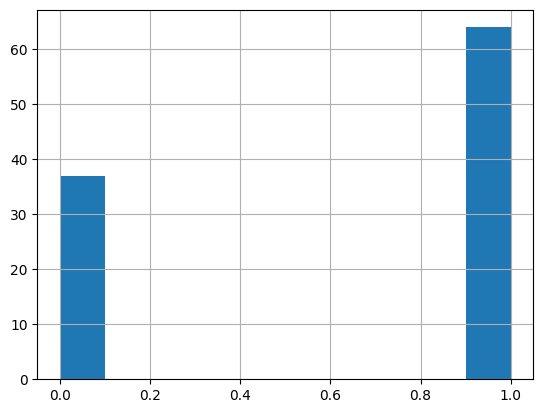

In [7]:
minor_powers['cost'].hist()

## What elements are most common in major powers?

In [8]:
major_powers = df[df['type'] == 'Major Power']
major_powers = major_powers.join(major_powers['elements'].str.get_dummies(sep=','))
counts = major_powers[elements].sum()
counts

,0
Air,30
Animal,29
Earth,30
Fire,29
Moon,30
Plant,30
Sun,30
Water,31


<Axes: >

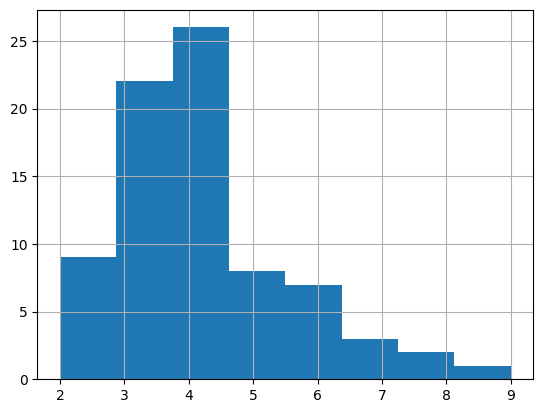

In [9]:
major_powers['cost'].hist(bins="auto")

What elements are most needed to threshold major powers?

In [10]:
major_powers['threshold'] = major_powers['description'].str.split('-', n=1, expand=True)[1]
major_powers['threshold'] = major_powers["description"].str.extract(r"If you have-(.*?):")[0]
print(major_powers['threshold'])


s = major_powers["threshold"]

# 1) Extract (amount, element) pairs from each row
pairs = s.str.findall(r"(\d+)\s*([A-Za-z]+)")

# 2) Explode into one pair per row, keeping original index
long = (
    pairs.explode()
         .dropna()
         .to_frame("pair")
)

# 3) Split the tuple into columns
long[["amount", "element"]] = pd.DataFrame(long["pair"].tolist(), index=long.index)
long["amount"] = long["amount"].astype(int)

# 4) Pivot to wide: one column per element
wide = long.pivot_table(index=long.index, columns="element", values="amount", aggfunc="max")

# 5) Rename columns to "{element}_threshold"
wide = wide.add_suffix("_threshold")

# 6) Join back to your dataframe
major_powers = major_powers.join(wide)

# Optional: fill missing requirements with 0
major_powers[wide.columns] = major_powers[wide.columns].fillna(0).astype(int)


68         3 Sun, 2 Water, 3 Plant
69                         4 Water
70                          4 Fire
71      3 Earth, 2 Plant, 2 Animal
72                          4 Moon
                  ...             
292               3 Water, 2 Plant
293                        4 Earth
294         2 Sun, 2 Moon, 2 Earth
295        2 Moon, 3 Fire, 2 Plant
296      2 Moon, 3 Earth, 3 Animal
Name: threshold, Length: 78, dtype: object


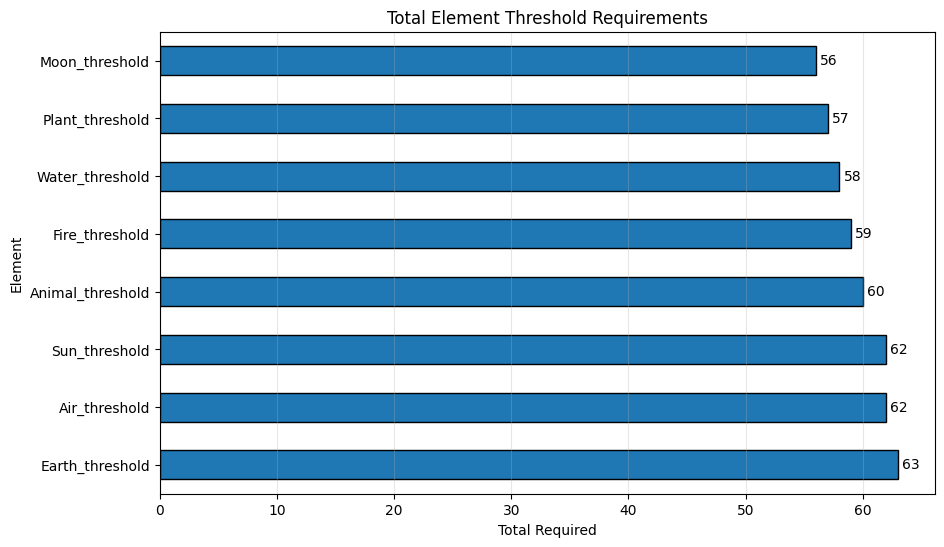

In [11]:
threshold_cols = [c for c in major_powers.columns if c.endswith("_threshold")]

totals = major_powers[threshold_cols].sum().sort_values(ascending=False)

import matplotlib.pyplot as plt

ax = totals.plot(
    kind="barh",
    figsize=(10, 6),
    edgecolor="black"
)

ax.set_title("Total Element Threshold Requirements")
ax.set_xlabel("Total Required")
ax.set_ylabel("Element")
ax.grid(axis="x", alpha=0.3)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, padding=3)



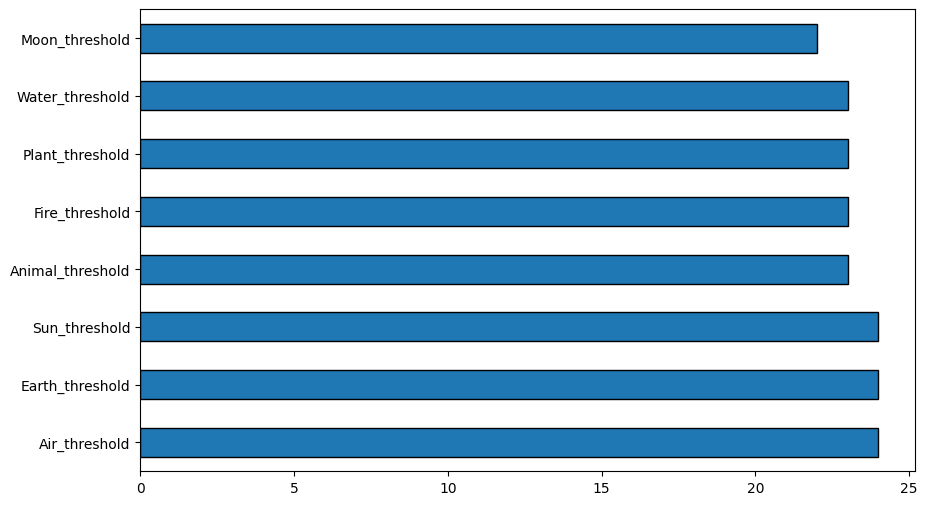

In [12]:
card_counts = (major_powers[threshold_cols] >= 1).sum().sort_values(ascending=False)


ax = card_counts.plot(
    kind="barh",
    figsize=(10, 6),
    edgecolor="black"
)

# section 2: the games

## what cards taken in Spirit Island go to the best winrate?


In [17]:
df = pd.read_csv('GameResult2.csv')
df['Win'] = df['endingResult'].str.contains('Win')
df['Win']


,Win
0,False
1,True
2,True
3,True
4,True
...,...
995,True
996,False
997,True
998,True


In [22]:
df['powerCardsOwned'][0]
df = df.join(df['spirits'].str.get_dummies(sep=','))

In [29]:
df.groupby('LightningsSwiftStrike')['Win']
spirits = list(df['spirits'].str.get_dummies(sep=',').columns)

In [37]:
win_counts = {}
for spirit in spirits:
    win_counts[spirit] = df[df[spirit] == 1]['Win'].sum()

win_counts = pd.Series(win_counts)
games_played = df[spirits].sum()
spirit_winrate_df = pd.DataFrame({
    'wins': win_counts,
    'total_played': games_played
})
spirit_winrate_df
spirit_winrate_df['winrate'] = spirit_winrate_df['wins'] / spirit_winrate_df['total_played']
spirit_winrate_df.sort_values('winrate')

,wins,total_played,winrate
SerpentSlumberingBeneathTheIsland,36,69,0.521739
VitalStrengthOfTheEarth,8,15,0.533333
SerpentSlumberingBeneathTheIsland,14,24,0.583333
SunBrightWhirlwind,103,171,0.602339
BringerOfDreamsAndNightmares,37,53,0.698113
SharpFangsBehindTheLeaves,21,30,0.700000
HeartOfTheWildfire,12,17,0.705882
LightningsSwiftStrike,22,31,0.709677
DevouringTeethLurkUnderfoot,42,59,0.711864
ShadowsFlickerLikeFlame,13,18,0.722222
